# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ac                      1206 non-null   int64  
 1   dex                     1206 non-null   int64  
 2   reflex                  1206 non-null   int64  
 3   perception              1206 non-null   int64  
 4   num_immunities          1206 non-null   int64  
 5   fortitude               1206 non-null   int64  
 6   int                     1206 non-null   int64  
 7   wis                     1206 non-null   int64  
 8   hp                      1206 non-null   int64  
 9   will                    1206 non-null   int64  
 10  focus                   1206 non-null   int32  
 11  level                   1206 non-null   int64  
 12  book                    1206 non-null   object 
 13  con                     1206 non-null   int64  
 14  cha                     1206 non-null   

In [3]:
df.head()

,ac,dex,reflex,perception,num_immunities,fortitude,int,wis,hp,will,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,29,2,19,20,3,22,1,2,215,17,...,0,0,0,0,0,0,23,22.0,0,0.0
1,28,0,14,16,0,21,-4,2,220,16,...,0,0,0,0,0,0,23,22.0,0,0.0
2,25,3,17,17,0,20,-4,3,175,15,...,0,0,0,0,0,0,21,16.0,0,0.0
3,41,4,29,30,3,30,6,5,315,32,...,1,0,1,0,0,0,33,31.5,0,0.0
4,16,3,10,6,0,6,-1,1,20,4,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


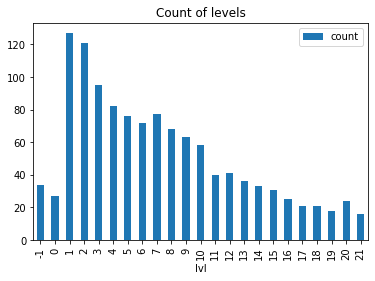

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not m

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.91
RMSE: 0.96
MAE: 0.46


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.11
RMSE test: 0.96


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

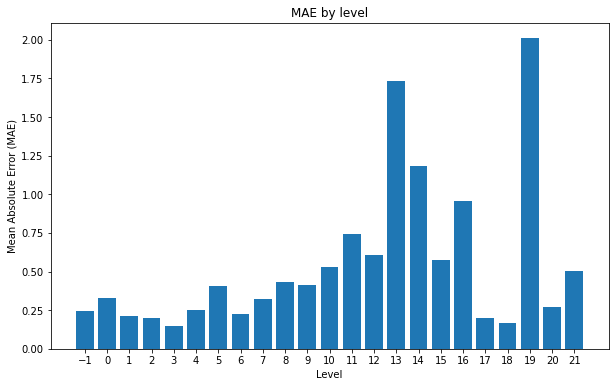

In [18]:
plot_mae_by_level(y_test, y_pred_test)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.91
RMSE: 0.96

Round type: round
MSE: 0.94
RMSE: 0.97

Round type: 0.33
MSE: 0.91
RMSE: 0.96

Round type: 0.45
MSE: 0.90
RMSE: 0.95



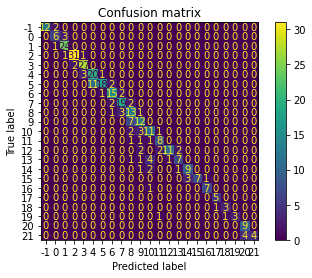

In [20]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 13:51:46,452] A new study created in memory with name: no-name-786df58b-8688-473b-a3d0-9ad862660246
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.141966 + 0.0307739
[200]	cv_agg's l2: 0.138724 + 0.0299803
[300]	cv_agg's l2: 0.137928 + 0.0294349
[400]	cv_agg's l2: 0.137663 + 0.0294396
[500]	cv_agg's l2: 0.137494 + 0.0292925
[600]	cv_agg's l2: 0.137429 + 0.0292935
[700]	cv_agg's l2: 0.13742 + 0.0293965


feature_fraction, val_score: 0.137355:  14%|######4                                      | 1/7 [00:15<01:31, 15.27s/it]

Early stopping, best iteration is:
[666]	cv_agg's l2: 0.137355 + 0.0293748
[100]	cv_agg's l2: 0.141087 + 0.0319219
[200]	cv_agg's l2: 0.13831 + 0.0301992
[300]	cv_agg's l2: 0.136812 + 0.0294985
[400]	cv_agg's l2: 0.135911 + 0.0296365
[500]	cv_agg's l2: 0.135939 + 0.0294235


feature_fraction, val_score: 0.135787:  29%|############8                                | 2/7 [00:25<01:02, 12.45s/it]

Early stopping, best iteration is:
[457]	cv_agg's l2: 0.135787 + 0.029443
[100]	cv_agg's l2: 0.144932 + 0.0354833
[200]	cv_agg's l2: 0.140918 + 0.0350618
[300]	cv_agg's l2: 0.139622 + 0.0340435
[400]	cv_agg's l2: 0.138968 + 0.0332552
[500]	cv_agg's l2: 0.138552 + 0.0333019


feature_fraction, val_score: 0.135787:  43%|###################2                         | 3/7 [00:35<00:45, 11.33s/it]

Early stopping, best iteration is:
[457]	cv_agg's l2: 0.135787 + 0.029443
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


feature_fraction, val_score: 0.134872:  57%|#########################7                   | 4/7 [00:41<00:27,  9.31s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.152168 + 0.0369166
[200]	cv_agg's l2: 0.149945 + 0.0370571
[300]	cv_agg's l2: 0.149451 + 0.0369843


feature_fraction, val_score: 0.134872:  71%|################################1            | 5/7 [00:48<00:16,  8.21s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.149446 + 0.0345664
[200]	cv_agg's l2: 0.146274 + 0.034474
[300]	cv_agg's l2: 0.145863 + 0.0343339


feature_fraction, val_score: 0.134872:  86%|######################################5      | 6/7 [00:56<00:08,  8.10s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.141479 + 0.0350286
[200]	cv_agg's l2: 0.135993 + 0.0323897
[300]	cv_agg's l2: 0.135652 + 0.0315328


feature_fraction, val_score: 0.134872: 100%|#############################################| 7/7 [01:04<00:00,  9.18s/it]


Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268


num_leaves, val_score: 0.134872:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:   5%|##5                                               | 1/20 [00:07<02:21,  7.46s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  10%|#####                                             | 2/20 [00:16<02:33,  8.53s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  15%|#######5                                          | 3/20 [00:23<02:09,  7.64s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  20%|##########                                        | 4/20 [00:29<01:54,  7.17s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.141415 + 0.0272483
[200]	cv_agg's l2: 0.136211 + 0.0256533
[300]	cv_agg's l2: 0.135798 + 0.0247016


num_leaves, val_score: 0.134872:  25%|############5                                     | 5/20 [00:33<01:28,  5.88s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  30%|###############                                   | 6/20 [00:39<01:23,  5.97s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  35%|#################5                                | 7/20 [00:46<01:20,  6.20s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  40%|####################                              | 8/20 [00:52<01:16,  6.37s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  45%|######################5                           | 9/20 [00:59<01:10,  6.43s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  50%|########################5                        | 10/20 [01:07<01:09,  6.95s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  55%|##########################9                      | 11/20 [01:19<01:16,  8.49s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.279507 + 0.0431361
[200]	cv_agg's l2: 0.248171 + 0.0399418


num_leaves, val_score: 0.134872:  60%|#############################4                   | 12/20 [01:20<00:49,  6.22s/it]

[300]	cv_agg's l2: 0.240852 + 0.0377117
Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  65%|###############################8                 | 13/20 [01:29<00:48,  6.91s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  70%|##################################3              | 14/20 [01:37<00:44,  7.43s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  75%|####################################7            | 15/20 [01:44<00:35,  7.10s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  80%|#######################################2         | 16/20 [01:49<00:26,  6.58s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134872:  85%|#########################################6       | 17/20 [01:53<00:17,  5.95s/it]

Early stopping, best iteration is:
[258]	cv_agg's l2: 0.134872 + 0.0276268
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135369 + 0.0282791
[300]	cv_agg's l2: 0.134836 + 0.0279063


num_leaves, val_score: 0.134611:  90%|############################################1    | 18/20 [01:58<00:11,  5.55s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134611:  95%|##############################################5  | 19/20 [02:03<00:05,  5.28s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139189 + 0.030512
[200]	cv_agg's l2: 0.135563 + 0.028169
[300]	cv_agg's l2: 0.13502 + 0.0277975


num_leaves, val_score: 0.134611: 100%|#################################################| 20/20 [02:08<00:00,  6.41s/it]


Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918


bagging, val_score: 0.134611:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.150218 + 0.033425
[200]	cv_agg's l2: 0.146592 + 0.0321107
[300]	cv_agg's l2: 0.145632 + 0.0317633


bagging, val_score: 0.134611:  10%|#####3                                               | 1/10 [00:04<00:36,  4.10s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.196071 + 0.0339247
[200]	cv_agg's l2: 0.182051 + 0.036763
[300]	cv_agg's l2: 0.17824 + 0.0360129


bagging, val_score: 0.134611:  20%|##########6                                          | 2/10 [00:06<00:24,  3.08s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.142492 + 0.0310843
[200]	cv_agg's l2: 0.138717 + 0.0295024
[300]	cv_agg's l2: 0.137859 + 0.028731


bagging, val_score: 0.134611:  30%|###############9                                     | 3/10 [00:11<00:28,  4.03s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.174273 + 0.0260082
[200]	cv_agg's l2: 0.167574 + 0.023702
[300]	cv_agg's l2: 0.168198 + 0.0245157


bagging, val_score: 0.134611:  40%|#####################2                               | 4/10 [00:20<00:36,  6.05s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.159932 + 0.0306411
[200]	cv_agg's l2: 0.156081 + 0.0293935
[300]	cv_agg's l2: 0.154833 + 0.0289698


bagging, val_score: 0.134611:  50%|##########################5                          | 5/10 [00:27<00:32,  6.45s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.194465 + 0.0328871
[200]	cv_agg's l2: 0.18482 + 0.0291073
[300]	cv_agg's l2: 0.186342 + 0.0292166


bagging, val_score: 0.134611:  60%|###############################8                     | 6/10 [00:31<00:22,  5.59s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.154414 + 0.0307647
[200]	cv_agg's l2: 0.150464 + 0.0270484
[300]	cv_agg's l2: 0.149255 + 0.0276954


bagging, val_score: 0.134611:  70%|#####################################                | 7/10 [00:36<00:15,  5.15s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.165284 + 0.0212896
[200]	cv_agg's l2: 0.15751 + 0.0199643
[300]	cv_agg's l2: 0.156579 + 0.0196152


bagging, val_score: 0.134611:  80%|##########################################4          | 8/10 [00:39<00:09,  4.75s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.174457 + 0.0405268
[200]	cv_agg's l2: 0.164265 + 0.0384061
[300]	cv_agg's l2: 0.160931 + 0.0340146


bagging, val_score: 0.134611:  90%|###############################################7     | 9/10 [00:42<00:04,  4.20s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.154005 + 0.0275911
[200]	cv_agg's l2: 0.150018 + 0.0259499
[300]	cv_agg's l2: 0.148828 + 0.0251355


bagging, val_score: 0.134611: 100%|####################################################| 10/10 [00:46<00:00,  4.64s/it]


Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918


feature_fraction_stage2, val_score: 0.134611:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.140797 + 0.0280936
[200]	cv_agg's l2: 0.136937 + 0.0266252
[300]	cv_agg's l2: 0.136079 + 0.0259208


feature_fraction_stage2, val_score: 0.134611:  17%|######3                               | 1/6 [00:04<00:20,  4.01s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.145269 + 0.0361091
[200]	cv_agg's l2: 0.142421 + 0.0354184
[300]	cv_agg's l2: 0.141793 + 0.0355715


feature_fraction_stage2, val_score: 0.134611:  33%|############6                         | 2/6 [00:07<00:15,  3.93s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.13866 + 0.0246674
[200]	cv_agg's l2: 0.135754 + 0.0238709
[300]	cv_agg's l2: 0.135816 + 0.0241302


feature_fraction_stage2, val_score: 0.134611:  50%|###################                   | 3/6 [00:12<00:12,  4.02s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.144883 + 0.0291644
[200]	cv_agg's l2: 0.142473 + 0.0287141
[300]	cv_agg's l2: 0.141584 + 0.0285951


feature_fraction_stage2, val_score: 0.134611:  67%|#########################3            | 4/6 [00:17<00:09,  4.55s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.148706 + 0.0350208
[200]	cv_agg's l2: 0.144555 + 0.0330377
[300]	cv_agg's l2: 0.144156 + 0.0332276


feature_fraction_stage2, val_score: 0.134611:  83%|###############################6      | 5/6 [00:21<00:04,  4.34s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.138724 + 0.0260985
[200]	cv_agg's l2: 0.135884 + 0.0247783
[300]	cv_agg's l2: 0.135562 + 0.0242667


feature_fraction_stage2, val_score: 0.134611: 100%|######################################| 6/6 [00:25<00:00,  4.29s/it]


Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918


regularization_factors, val_score: 0.134611:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.139972 + 0.0313007
[200]	cv_agg's l2: 0.137419 + 0.0310985
[300]	cv_agg's l2: 0.136923 + 0.029717


regularization_factors, val_score: 0.134611:   5%|#9                                    | 1/20 [00:04<01:31,  4.80s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.146573 + 0.0277244
[200]	cv_agg's l2: 0.141578 + 0.0278289
[300]	cv_agg's l2: 0.14045 + 0.0276283


regularization_factors, val_score: 0.134611:  10%|###8                                  | 2/20 [00:08<01:17,  4.28s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.160678 + 0.0267662
[200]	cv_agg's l2: 0.156763 + 0.0263421
[300]	cv_agg's l2: 0.156672 + 0.0262777


regularization_factors, val_score: 0.134611:  15%|#####7                                | 3/20 [00:09<00:49,  2.89s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.141042 + 0.029551
[200]	cv_agg's l2: 0.137189 + 0.0277009
[300]	cv_agg's l2: 0.137092 + 0.0277804


regularization_factors, val_score: 0.134611:  20%|#######6                              | 4/20 [00:14<00:53,  3.37s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.140566 + 0.029953
[200]	cv_agg's l2: 0.136798 + 0.0278121
[300]	cv_agg's l2: 0.136017 + 0.0275733


regularization_factors, val_score: 0.134611:  25%|#########5                            | 5/20 [00:18<00:54,  3.63s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.204075 + 0.0320609
[200]	cv_agg's l2: 0.202456 + 0.0317748


regularization_factors, val_score: 0.134611:  30%|###########4                          | 6/20 [00:19<00:37,  2.69s/it]

[300]	cv_agg's l2: 0.202456 + 0.031775
Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.138973 + 0.0295948
[200]	cv_agg's l2: 0.135787 + 0.0284593
[300]	cv_agg's l2: 0.135289 + 0.0279028


regularization_factors, val_score: 0.134611:  35%|#############3                        | 7/20 [00:23<00:41,  3.20s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.141965 + 0.0307538
[200]	cv_agg's l2: 0.1381 + 0.0291405
[300]	cv_agg's l2: 0.138026 + 0.0292725


regularization_factors, val_score: 0.134611:  40%|###############2                      | 8/20 [00:27<00:41,  3.47s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134825 + 0.0278615


regularization_factors, val_score: 0.134611:  45%|#################1                    | 9/20 [00:31<00:42,  3.84s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.13907 + 0.0306059
[200]	cv_agg's l2: 0.135535 + 0.0281643
[300]	cv_agg's l2: 0.135171 + 0.027635


regularization_factors, val_score: 0.134611:  50%|##################5                  | 10/20 [00:36<00:39,  3.99s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134825 + 0.0278615


regularization_factors, val_score: 0.134611:  55%|####################3                | 11/20 [00:41<00:38,  4.32s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134825 + 0.0278615


regularization_factors, val_score: 0.134611:  60%|######################2              | 12/20 [00:46<00:36,  4.53s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134825 + 0.0278615


regularization_factors, val_score: 0.134611:  65%|########################             | 13/20 [00:52<00:34,  4.87s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.13907 + 0.0306059
[200]	cv_agg's l2: 0.135535 + 0.0281643
[300]	cv_agg's l2: 0.135171 + 0.027635


regularization_factors, val_score: 0.134611:  70%|#########################9           | 14/20 [00:56<00:28,  4.70s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134825 + 0.0278615


regularization_factors, val_score: 0.134611:  75%|###########################7         | 15/20 [01:01<00:24,  4.99s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134825 + 0.0278615


regularization_factors, val_score: 0.134611:  80%|#############################6       | 16/20 [01:05<00:18,  4.67s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139747 + 0.0301541
[200]	cv_agg's l2: 0.135953 + 0.0283276
[300]	cv_agg's l2: 0.135645 + 0.0278103


regularization_factors, val_score: 0.134611:  85%|###############################4     | 17/20 [01:08<00:12,  4.18s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139373 + 0.0303705
[200]	cv_agg's l2: 0.135225 + 0.0283821
[300]	cv_agg's l2: 0.134821 + 0.0278642


regularization_factors, val_score: 0.134611:  90%|#################################3   | 18/20 [01:11<00:07,  3.68s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.13907 + 0.0306059
[200]	cv_agg's l2: 0.135535 + 0.0281643
[300]	cv_agg's l2: 0.135171 + 0.027635


regularization_factors, val_score: 0.134611:  95%|###################################1 | 19/20 [01:13<00:03,  3.28s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.139747 + 0.0301541
[200]	cv_agg's l2: 0.135765 + 0.0284582
[300]	cv_agg's l2: 0.135145 + 0.0279908


regularization_factors, val_score: 0.134611: 100%|#####################################| 20/20 [01:16<00:00,  3.83s/it]


Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918


min_data_in_leaf, val_score: 0.134611:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.213713 + 0.0443241
[200]	cv_agg's l2: 0.204527 + 0.0460435
[300]	cv_agg's l2: 0.203355 + 0.0486183
Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918


min_data_in_leaf, val_score: 0.134611:  20%|#########                                    | 1/5 [00:01<00:04,  1.18s/it]

[100]	cv_agg's l2: 0.15995 + 0.0342644
[200]	cv_agg's l2: 0.154377 + 0.031596
[300]	cv_agg's l2: 0.153304 + 0.030803


min_data_in_leaf, val_score: 0.134611:  40%|##################                           | 2/5 [00:03<00:05,  1.71s/it]

Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.706967 + 0.122441
[200]	cv_agg's l2: 0.672294 + 0.131167


min_data_in_leaf, val_score: 0.134611:  60%|###########################                  | 3/5 [00:03<00:02,  1.26s/it]

[300]	cv_agg's l2: 0.661062 + 0.135389
Early stopping, best iteration is:
[257]	cv_agg's l2: 0.134611 + 0.0276918
[100]	cv_agg's l2: 0.129715 + 0.0210057
[200]	cv_agg's l2: 0.128187 + 0.0213187
[300]	cv_agg's l2: 0.128022 + 0.0214896
[400]	cv_agg's l2: 0.127983 + 0.0215525
[500]	cv_agg's l2: 0.127919 + 0.0215317
[600]	cv_agg's l2: 0.127895 + 0.0215419
[700]	cv_agg's l2: 0.127883 + 0.0215464
[800]	cv_agg's l2: 0.12788 + 0.021546
[900]	cv_agg's l2: 0.127879 + 0.0215461
[1000]	cv_agg's l2: 0.127878 + 0.0215463
[1100]	cv_agg's l2: 0.127878 + 0.0215466
[1200]	cv_agg's l2: 0.127878 + 0.0215465
[1300]	cv_agg's l2: 0.127878 + 0.0215465
[1400]	cv_agg's l2: 0.127878 + 0.0215464
[1500]	cv_agg's l2: 0.127878 + 0.0215464
[1600]	cv_agg's l2: 0.127878 + 0.0215464
[1700]	cv_agg's l2: 0.127878 + 0.0215464
[1800]	cv_agg's l2: 0.127878 + 0.0215464
[1900]	cv_agg's l2: 0.127878 + 0.0215464
[2000]	cv_agg's l2: 0.127878 + 0.0215464
[2100]	cv_agg's l2: 0.127878 + 0.0215464
[2200]	cv_agg's l2: 0.127878 + 0.021

min_data_in_leaf, val_score: 0.127878:  80%|####################################         | 4/5 [00:28<00:10, 10.33s/it]

[2900]	cv_agg's l2: 0.127878 + 0.0215464
Early stopping, best iteration is:
[2802]	cv_agg's l2: 0.127878 + 0.0215464
[100]	cv_agg's l2: 0.131779 + 0.0226457
[200]	cv_agg's l2: 0.131558 + 0.0228607
[300]	cv_agg's l2: 0.131374 + 0.0230696
[400]	cv_agg's l2: 0.13133 + 0.0231312
[500]	cv_agg's l2: 0.131323 + 0.0231141
[600]	cv_agg's l2: 0.13136 + 0.0231569
[700]	cv_agg's l2: 0.131356 + 0.0231911
[800]	cv_agg's l2: 0.131349 + 0.0232057
[900]	cv_agg's l2: 0.131341 + 0.0232089
[1000]	cv_agg's l2: 0.13133 + 0.0232182
[1100]	cv_agg's l2: 0.131324 + 0.0232228
[1200]	cv_agg's l2: 0.13132 + 0.0232269
[1300]	cv_agg's l2: 0.131317 + 0.0232304
[1400]	cv_agg's l2: 0.131314 + 0.023234
[1500]	cv_agg's l2: 0.131313 + 0.0232355
[1600]	cv_agg's l2: 0.131311 + 0.0232385
[1700]	cv_agg's l2: 0.131311 + 0.0232382
[1800]	cv_agg's l2: 0.13131 + 0.0232391
[1900]	cv_agg's l2: 0.131309 + 0.0232401
[2000]	cv_agg's l2: 0.13131 + 0.0232397
[2100]	cv_agg's l2: 0.13131 + 0.0232397
[2200]	cv_agg's l2: 0.13131 + 0.0232397

min_data_in_leaf, val_score: 0.127878: 100%|#############################################| 5/5 [01:09<00:00, 13.93s/it]

[2900]	cv_agg's l2: 0.13131 + 0.0232399
Early stopping, best iteration is:
[2802]	cv_agg's l2: 0.127878 + 0.0215464


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12787795426143006
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 29
    feature_fraction: 0.8
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.88
MSE test: 0.77
MAE test: 0.44



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

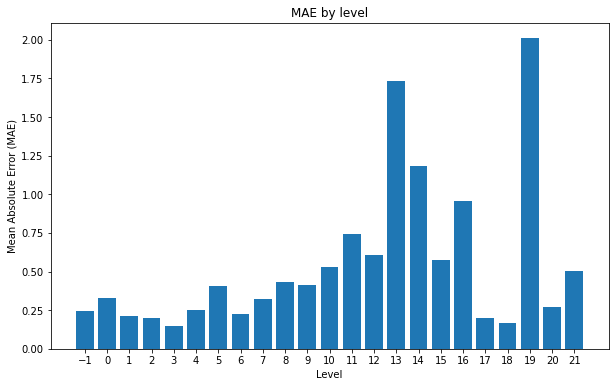

In [27]:
plot_mae_by_level(y_test, y_pred_test)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.77
RMSE: 0.88

Round type: round
MSE: 0.80
RMSE: 0.89

Round type: 0.33
MSE: 0.78
RMSE: 0.88

Round type: 0.45
MSE: 0.78
RMSE: 0.88



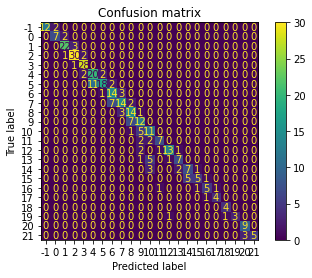

In [29]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.246737	valid_0's l2: 0.1379


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.14
RMSE: 0.37
MAE: 0.25


In [33]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

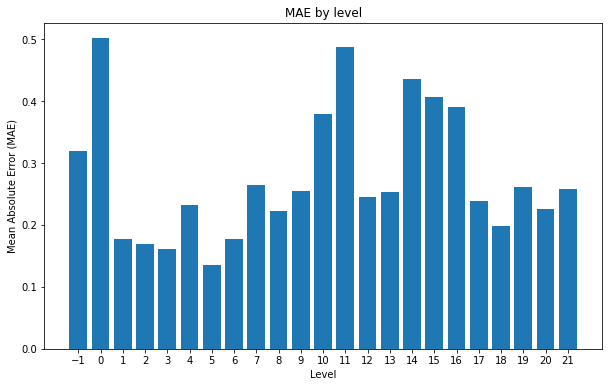

In [34]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.14
RMSE: 0.37

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.19
RMSE: 0.43

Round type: 0.45
MSE: 0.15
RMSE: 0.38



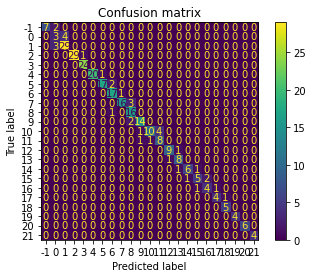

In [36]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 13:59:12,922] A new study created in memory with name: no-name-2bee595b-291e-40e7-af33-4aa720de6647
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13778 + 0.0213617
[300]	cv_agg's l2: 0.136104 + 0.0200901
[400]	cv_agg's l2: 0.135712 + 0.0197729
[500]	cv_agg's l2: 0.135215 + 0.0195215
[600]	cv_agg's l2: 0.13503 + 0.0193277
[700]	cv_agg's l2: 0.134819 + 0.0191627
[800]	cv_agg's l2: 0.134703 + 0.019073
[900]	cv_agg's l2: 0.134714 + 0.0190109


feature_fraction, val_score: 0.134667:  14%|######4                                      | 1/7 [00:12<01:12, 12.12s/it]

Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514
[100]	cv_agg's l2: 0.171543 + 0.0383237
[200]	cv_agg's l2: 0.167466 + 0.0373908
[300]	cv_agg's l2: 0.166283 + 0.0366186
[400]	cv_agg's l2: 0.165984 + 0.0363403
[500]	cv_agg's l2: 0.166001 + 0.0361512
[600]	cv_agg's l2: 0.166099 + 0.0361272
[700]	cv_agg's l2: 0.166051 + 0.0360338
[800]	cv_agg's l2: 0.166028 + 0.0359957
[900]	cv_agg's l2: 0.166053 + 0.0359343


feature_fraction, val_score: 0.134667:  29%|############8                                | 2/7 [00:23<00:59, 11.97s/it]

Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514
[100]	cv_agg's l2: 0.160002 + 0.0361861
[200]	cv_agg's l2: 0.157426 + 0.0350442
[300]	cv_agg's l2: 0.156467 + 0.0339897
[400]	cv_agg's l2: 0.15626 + 0.0336526
[500]	cv_agg's l2: 0.156057 + 0.0333373
[600]	cv_agg's l2: 0.156067 + 0.0332054
[700]	cv_agg's l2: 0.155993 + 0.0329547
[800]	cv_agg's l2: 0.155974 + 0.032815
[900]	cv_agg's l2: 0.155938 + 0.0327344


feature_fraction, val_score: 0.134667:  43%|###################2                         | 3/7 [00:34<00:45, 11.30s/it]

Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514
[100]	cv_agg's l2: 0.145888 + 0.0287949
[200]	cv_agg's l2: 0.144216 + 0.0268886
[300]	cv_agg's l2: 0.143194 + 0.025674
[400]	cv_agg's l2: 0.143016 + 0.0250472
[500]	cv_agg's l2: 0.142529 + 0.0249156
[600]	cv_agg's l2: 0.142197 + 0.0245736
[700]	cv_agg's l2: 0.142087 + 0.0245059
[800]	cv_agg's l2: 0.142027 + 0.0244671
[900]	cv_agg's l2: 0.141952 + 0.0243638


feature_fraction, val_score: 0.134667:  57%|#########################7                   | 4/7 [00:46<00:34, 11.50s/it]

Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514
[100]	cv_agg's l2: 0.181766 + 0.0616563
[200]	cv_agg's l2: 0.17838 + 0.0595271
[300]	cv_agg's l2: 0.176719 + 0.0575478
[400]	cv_agg's l2: 0.175422 + 0.0562756
[500]	cv_agg's l2: 0.174844 + 0.0555277
[600]	cv_agg's l2: 0.17478 + 0.0551626
[700]	cv_agg's l2: 0.174598 + 0.0548763
[800]	cv_agg's l2: 0.174493 + 0.0547107
[900]	cv_agg's l2: 0.174379 + 0.0545195


feature_fraction, val_score: 0.134667:  71%|################################1            | 5/7 [00:58<00:23, 11.83s/it]

Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514
[100]	cv_agg's l2: 0.158356 + 0.0453444
[200]	cv_agg's l2: 0.156212 + 0.0422413
[300]	cv_agg's l2: 0.155324 + 0.0406649
[400]	cv_agg's l2: 0.154667 + 0.0396775
[500]	cv_agg's l2: 0.154439 + 0.0394894
[600]	cv_agg's l2: 0.154312 + 0.0394405
[700]	cv_agg's l2: 0.154084 + 0.0392172
[800]	cv_agg's l2: 0.153993 + 0.0390601
[900]	cv_agg's l2: 0.153959 + 0.0390403


feature_fraction, val_score: 0.134667:  86%|######################################5      | 6/7 [01:10<00:11, 11.77s/it]

Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514
[100]	cv_agg's l2: 0.159626 + 0.0379434
[200]	cv_agg's l2: 0.15676 + 0.0356162
[300]	cv_agg's l2: 0.155895 + 0.0341011
[400]	cv_agg's l2: 0.155149 + 0.0331573
[500]	cv_agg's l2: 0.154912 + 0.0328459
[600]	cv_agg's l2: 0.154718 + 0.0326854
[700]	cv_agg's l2: 0.154668 + 0.0326551
[800]	cv_agg's l2: 0.154553 + 0.0325036


feature_fraction, val_score: 0.134667:  86%|######################################5      | 6/7 [01:22<00:11, 11.77s/it]

[900]	cv_agg's l2: 0.154433 + 0.032501
Early stopping, best iteration is:
[821]	cv_agg's l2: 0.134667 + 0.0190514


num_leaves, val_score: 0.134667:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.142749 + 0.0226578
[200]	cv_agg's l2: 0.136269 + 0.0204972
[300]	cv_agg's l2: 0.134364 + 0.0190944
[400]	cv_agg's l2: 0.13378 + 0.0184919
[500]	cv_agg's l2: 0.133331 + 0.0181503
[600]	cv_agg's l2: 0.133273 + 0.0179798


num_leaves, val_score: 0.133202:   5%|##5                                               | 1/20 [00:05<01:41,  5.36s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  10%|#####                                             | 2/20 [00:14<02:11,  7.29s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  15%|#######5                                          | 3/20 [00:23<02:18,  8.14s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.237433 + 0.0544622
[200]	cv_agg's l2: 0.20796 + 0.0501258
[300]	cv_agg's l2: 0.195451 + 0.0509901
[400]	cv_agg's l2: 0.186071 + 0.0486365
[500]	cv_agg's l2: 0.179533 + 0.046678
[600]	cv_agg's l2: 0.174347 + 0.0452285


num_leaves, val_score: 0.133202:  20%|##########                                        | 4/20 [00:25<01:31,  5.71s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  25%|############5                                     | 5/20 [00:33<01:42,  6.84s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  30%|###############                                   | 6/20 [00:42<01:44,  7.49s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  35%|#################5                                | 7/20 [00:51<01:42,  7.92s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  40%|####################                              | 8/20 [01:00<01:38,  8.24s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  45%|######################5                           | 9/20 [01:09<01:33,  8.46s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.161976 + 0.038733
[200]	cv_agg's l2: 0.147075 + 0.0334942
[300]	cv_agg's l2: 0.142318 + 0.0309204
[400]	cv_agg's l2: 0.138893 + 0.0292706
[500]	cv_agg's l2: 0.137427 + 0.0296827
[600]	cv_agg's l2: 0.136197 + 0.0290696


num_leaves, val_score: 0.133202:  50%|########################5                        | 10/20 [01:12<01:08,  6.81s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  55%|##########################9                      | 11/20 [01:21<01:07,  7.45s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  60%|#############################4                   | 12/20 [01:30<01:03,  7.96s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  65%|###############################8                 | 13/20 [01:39<00:57,  8.27s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  70%|##################################3              | 14/20 [01:48<00:50,  8.42s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  75%|####################################7            | 15/20 [01:57<00:43,  8.66s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  80%|#######################################2         | 16/20 [02:06<00:35,  8.88s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  85%|#########################################6       | 17/20 [02:16<00:26,  8.98s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  90%|############################################1    | 18/20 [02:24<00:17,  8.93s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202:  95%|##############################################5  | 19/20 [02:33<00:08,  8.87s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141687 + 0.0221908
[200]	cv_agg's l2: 0.13785 + 0.0213589
[300]	cv_agg's l2: 0.136095 + 0.0200902
[400]	cv_agg's l2: 0.135507 + 0.0197683
[500]	cv_agg's l2: 0.134916 + 0.0195129
[600]	cv_agg's l2: 0.134715 + 0.019317


num_leaves, val_score: 0.133202: 100%|#################################################| 20/20 [02:42<00:00,  8.11s/it]


Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492


bagging, val_score: 0.133202:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.151542 + 0.0237288
[200]	cv_agg's l2: 0.142445 + 0.0217904
[300]	cv_agg's l2: 0.140084 + 0.0190315
[400]	cv_agg's l2: 0.139333 + 0.0199997
[500]	cv_agg's l2: 0.13899 + 0.0198503
[600]	cv_agg's l2: 0.138524 + 0.019907


bagging, val_score: 0.133202:  10%|#####3                                               | 1/10 [00:07<01:04,  7.17s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.20065 + 0.0249932
[200]	cv_agg's l2: 0.185728 + 0.0262079
[300]	cv_agg's l2: 0.181988 + 0.0224829
[400]	cv_agg's l2: 0.180643 + 0.0213449
[500]	cv_agg's l2: 0.180529 + 0.0201218
[600]	cv_agg's l2: 0.181519 + 0.0207889


bagging, val_score: 0.133202:  20%|##########6                                          | 2/10 [00:10<00:37,  4.73s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.148349 + 0.0221309
[200]	cv_agg's l2: 0.142222 + 0.0204705
[300]	cv_agg's l2: 0.140046 + 0.0198439
[400]	cv_agg's l2: 0.139031 + 0.0194657
[500]	cv_agg's l2: 0.138751 + 0.0194007
[600]	cv_agg's l2: 0.138537 + 0.0191427


bagging, val_score: 0.133202:  30%|###############9                                     | 3/10 [00:14<00:32,  4.62s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.211193 + 0.0297937
[200]	cv_agg's l2: 0.195911 + 0.0280128
[300]	cv_agg's l2: 0.19464 + 0.0258731
[400]	cv_agg's l2: 0.190647 + 0.0243881
[500]	cv_agg's l2: 0.18793 + 0.0236937
[600]	cv_agg's l2: 0.186277 + 0.0224957


bagging, val_score: 0.133202:  40%|#####################2                               | 4/10 [00:17<00:23,  3.85s/it]

Early stopping, best iteration is:
[575]	cv_agg's l2: 0.133202 + 0.0179492
[100]	cv_agg's l2: 0.141521 + 0.0256847
[200]	cv_agg's l2: 0.134906 + 0.0242749
[300]	cv_agg's l2: 0.133542 + 0.0241735
[400]	cv_agg's l2: 0.132785 + 0.0233376
[500]	cv_agg's l2: 0.132827 + 0.0230205
[600]	cv_agg's l2: 0.132719 + 0.0228638


bagging, val_score: 0.132645:  50%|##########################5                          | 5/10 [00:21<00:19,  4.00s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.147347 + 0.0321127
[200]	cv_agg's l2: 0.142902 + 0.030474
[300]	cv_agg's l2: 0.141731 + 0.0295502
[400]	cv_agg's l2: 0.141398 + 0.029234
[500]	cv_agg's l2: 0.141034 + 0.0292102
[600]	cv_agg's l2: 0.141103 + 0.0290972


bagging, val_score: 0.132645:  60%|###############################8                     | 6/10 [00:25<00:15,  3.99s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.150798 + 0.0307871
[200]	cv_agg's l2: 0.145844 + 0.0287511
[300]	cv_agg's l2: 0.145321 + 0.0294619
[400]	cv_agg's l2: 0.144587 + 0.0294385
[500]	cv_agg's l2: 0.144023 + 0.0289193
[600]	cv_agg's l2: 0.14423 + 0.0289442


bagging, val_score: 0.132645:  70%|#####################################                | 7/10 [00:29<00:11,  3.91s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.150993 + 0.0254363
[200]	cv_agg's l2: 0.145605 + 0.0226363
[300]	cv_agg's l2: 0.145011 + 0.0220185
[400]	cv_agg's l2: 0.144091 + 0.0215568
[500]	cv_agg's l2: 0.14405 + 0.021125
[600]	cv_agg's l2: 0.144085 + 0.0214695


bagging, val_score: 0.132645:  80%|##########################################4          | 8/10 [00:32<00:07,  3.79s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.141546 + 0.0238805
[200]	cv_agg's l2: 0.137285 + 0.0223292
[300]	cv_agg's l2: 0.136024 + 0.0215253
[400]	cv_agg's l2: 0.135565 + 0.0211018
[500]	cv_agg's l2: 0.13527 + 0.0205509
[600]	cv_agg's l2: 0.134961 + 0.0203684


bagging, val_score: 0.132645:  90%|###############################################7     | 9/10 [00:36<00:03,  3.90s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.176427 + 0.0256047
[200]	cv_agg's l2: 0.168294 + 0.0242512
[300]	cv_agg's l2: 0.163789 + 0.0226819
[400]	cv_agg's l2: 0.162106 + 0.0217912
[500]	cv_agg's l2: 0.161037 + 0.021909
[600]	cv_agg's l2: 0.15987 + 0.0214259
Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198


feature_fraction_stage2, val_score: 0.132645:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.149872 + 0.0363343
[200]	cv_agg's l2: 0.144843 + 0.0342307
[300]	cv_agg's l2: 0.142776 + 0.0332723
[400]	cv_agg's l2: 0.142486 + 0.0329325
[500]	cv_agg's l2: 0.142251 + 0.0325299
[600]	cv_agg's l2: 0.14195 + 0.032185


feature_fraction_stage2, val_score: 0.132645:  33%|############6                         | 1/3 [00:04<00:08,  4.09s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.143486 + 0.0240593
[200]	cv_agg's l2: 0.137921 + 0.0230562
[300]	cv_agg's l2: 0.136134 + 0.0219506
[400]	cv_agg's l2: 0.135309 + 0.0215646
[500]	cv_agg's l2: 0.135081 + 0.0214083
[600]	cv_agg's l2: 0.134885 + 0.0210182


feature_fraction_stage2, val_score: 0.132645:  67%|#########################3            | 2/3 [00:08<00:03,  3.99s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.15237 + 0.0356051
[200]	cv_agg's l2: 0.14865 + 0.0341314
[300]	cv_agg's l2: 0.147374 + 0.032585
[400]	cv_agg's l2: 0.147038 + 0.0325429
[500]	cv_agg's l2: 0.146949 + 0.0325854
[600]	cv_agg's l2: 0.14679 + 0.0326057


feature_fraction_stage2, val_score: 0.132645: 100%|######################################| 3/3 [00:12<00:00,  4.06s/it]


Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198


regularization_factors, val_score: 0.132645:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.140922 + 0.0260408
[200]	cv_agg's l2: 0.135948 + 0.0263924
[300]	cv_agg's l2: 0.134601 + 0.0254483
[400]	cv_agg's l2: 0.133845 + 0.0251037
[500]	cv_agg's l2: 0.133808 + 0.0252975
[600]	cv_agg's l2: 0.13389 + 0.0253714


regularization_factors, val_score: 0.132645:   5%|#9                                    | 1/20 [00:04<01:16,  4.00s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.142049 + 0.0277194
[200]	cv_agg's l2: 0.136236 + 0.0260424
[300]	cv_agg's l2: 0.134733 + 0.0257479
[400]	cv_agg's l2: 0.13435 + 0.024801
[500]	cv_agg's l2: 0.134177 + 0.0248138
[600]	cv_agg's l2: 0.134218 + 0.0246109


regularization_factors, val_score: 0.132645:  10%|###8                                  | 2/20 [00:07<01:09,  3.87s/it]

Early stopping, best iteration is:
[546]	cv_agg's l2: 0.132645 + 0.0229198
[100]	cv_agg's l2: 0.140013 + 0.0249173
[200]	cv_agg's l2: 0.133917 + 0.0246446
[300]	cv_agg's l2: 0.132442 + 0.0247375
[400]	cv_agg's l2: 0.131743 + 0.0239713
[500]	cv_agg's l2: 0.13147 + 0.0237006
[600]	cv_agg's l2: 0.131535 + 0.0238165


regularization_factors, val_score: 0.131377:  15%|#####7                                | 3/20 [00:11<01:04,  3.80s/it]

Early stopping, best iteration is:
[539]	cv_agg's l2: 0.131377 + 0.0237116
[100]	cv_agg's l2: 0.141475 + 0.0271253
[200]	cv_agg's l2: 0.136476 + 0.0269328
[300]	cv_agg's l2: 0.134623 + 0.0267097
[400]	cv_agg's l2: 0.134092 + 0.0258655
[500]	cv_agg's l2: 0.134081 + 0.0257719


regularization_factors, val_score: 0.131377:  15%|#####7                                | 3/20 [00:15<01:04,  3.80s/it]

[600]	cv_agg's l2: 0.134126 + 0.0256788
Early stopping, best iteration is:
[539]	cv_agg's l2: 0.131377 + 0.0237116


regularization_factors, val_score: 0.131377:  20%|#######6                              | 4/20 [00:15<01:00,  3.75s/it]

[100]	cv_agg's l2: 0.141537 + 0.0264513
[200]	cv_agg's l2: 0.136563 + 0.0258222
[300]	cv_agg's l2: 0.134485 + 0.0252774
[400]	cv_agg's l2: 0.133911 + 0.0248881
[500]	cv_agg's l2: 0.133751 + 0.0247616


regularization_factors, val_score: 0.131377:  25%|#########5                            | 5/20 [00:19<00:56,  3.79s/it]

[600]	cv_agg's l2: 0.13359 + 0.0247128
Early stopping, best iteration is:
[539]	cv_agg's l2: 0.131377 + 0.0237116
[100]	cv_agg's l2: 0.141643 + 0.0282898
[200]	cv_agg's l2: 0.137251 + 0.0275216
[300]	cv_agg's l2: 0.136038 + 0.0274229
[400]	cv_agg's l2: 0.135718 + 0.0269358
[500]	cv_agg's l2: 0.135498 + 0.0267023
[600]	cv_agg's l2: 0.135559 + 0.0266241


regularization_factors, val_score: 0.131377:  30%|###########4                          | 6/20 [00:22<00:53,  3.80s/it]

Early stopping, best iteration is:
[539]	cv_agg's l2: 0.131377 + 0.0237116
[100]	cv_agg's l2: 0.139153 + 0.0285219
[200]	cv_agg's l2: 0.135213 + 0.0280183
[300]	cv_agg's l2: 0.133302 + 0.0271045
[400]	cv_agg's l2: 0.13237 + 0.0261424
[500]	cv_agg's l2: 0.132279 + 0.0259779
[600]	cv_agg's l2: 0.132116 + 0.0255568


regularization_factors, val_score: 0.131377:  35%|#############3                        | 7/20 [00:26<00:50,  3.90s/it]

Early stopping, best iteration is:
[539]	cv_agg's l2: 0.131377 + 0.0237116
[100]	cv_agg's l2: 0.140426 + 0.0285403
[200]	cv_agg's l2: 0.134069 + 0.0272604
[300]	cv_agg's l2: 0.13196 + 0.0264753
[400]	cv_agg's l2: 0.131166 + 0.0260282
[500]	cv_agg's l2: 0.13109 + 0.0258783


regularization_factors, val_score: 0.130943:  40%|###############2                      | 8/20 [00:32<00:51,  4.27s/it]

[600]	cv_agg's l2: 0.13103 + 0.0256839
Early stopping, best iteration is:
[515]	cv_agg's l2: 0.130943 + 0.0258379
[100]	cv_agg's l2: 0.139474 + 0.028441
[200]	cv_agg's l2: 0.133302 + 0.0262139
[300]	cv_agg's l2: 0.131701 + 0.0255895
[400]	cv_agg's l2: 0.131081 + 0.0250142
[500]	cv_agg's l2: 0.131081 + 0.0249124
[600]	cv_agg's l2: 0.130752 + 0.024753
[700]	cv_agg's l2: 0.13066 + 0.024618
[800]	cv_agg's l2: 0.13061 + 0.0243947


regularization_factors, val_score: 0.130588:  45%|#################1                    | 9/20 [00:40<00:59,  5.44s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.140643 + 0.0281096
[200]	cv_agg's l2: 0.134551 + 0.0257343
[300]	cv_agg's l2: 0.132574 + 0.0254102
[400]	cv_agg's l2: 0.131724 + 0.0249827
[500]	cv_agg's l2: 0.131626 + 0.0248623
[600]	cv_agg's l2: 0.131467 + 0.024614
[700]	cv_agg's l2: 0.131362 + 0.0243975
[800]	cv_agg's l2: 0.131452 + 0.0243867


regularization_factors, val_score: 0.130588:  50%|##################5                  | 10/20 [00:48<01:03,  6.34s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.138528 + 0.0284964
[200]	cv_agg's l2: 0.134117 + 0.0268441
[300]	cv_agg's l2: 0.131508 + 0.0261498
[400]	cv_agg's l2: 0.131518 + 0.0250391
[500]	cv_agg's l2: 0.131373 + 0.0248621
[600]	cv_agg's l2: 0.131353 + 0.024601
[700]	cv_agg's l2: 0.131253 + 0.024484
[800]	cv_agg's l2: 0.131312 + 0.0244467


regularization_factors, val_score: 0.130588:  55%|####################3                | 11/20 [00:54<00:55,  6.15s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.139852 + 0.0281367
[200]	cv_agg's l2: 0.134148 + 0.0265777
[300]	cv_agg's l2: 0.132249 + 0.0258233
[400]	cv_agg's l2: 0.131252 + 0.0253741
[500]	cv_agg's l2: 0.131208 + 0.0251942
[600]	cv_agg's l2: 0.131281 + 0.0249366
[700]	cv_agg's l2: 0.131186 + 0.0248014
[800]	cv_agg's l2: 0.131166 + 0.0247501


regularization_factors, val_score: 0.130588:  60%|######################2              | 12/20 [00:59<00:48,  6.03s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.139668 + 0.0280802
[200]	cv_agg's l2: 0.134759 + 0.0267865
[300]	cv_agg's l2: 0.13316 + 0.025987
[400]	cv_agg's l2: 0.132525 + 0.0253167
[500]	cv_agg's l2: 0.132332 + 0.0250521
[600]	cv_agg's l2: 0.132458 + 0.0247249
[700]	cv_agg's l2: 0.132504 + 0.0245588
[800]	cv_agg's l2: 0.132426 + 0.0245061


regularization_factors, val_score: 0.130588:  65%|########################             | 13/20 [01:05<00:41,  5.98s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.138527 + 0.0284964
[200]	cv_agg's l2: 0.134117 + 0.026844
[300]	cv_agg's l2: 0.131595 + 0.0260826
[400]	cv_agg's l2: 0.131313 + 0.0252021
[500]	cv_agg's l2: 0.131186 + 0.0250773
[600]	cv_agg's l2: 0.131079 + 0.0249069
[700]	cv_agg's l2: 0.131088 + 0.0248457
[800]	cv_agg's l2: 0.131107 + 0.02477


regularization_factors, val_score: 0.130588:  70%|#########################9           | 14/20 [01:11<00:36,  6.03s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.138967 + 0.0283629
[200]	cv_agg's l2: 0.13433 + 0.0269385
[300]	cv_agg's l2: 0.132848 + 0.0267668
[400]	cv_agg's l2: 0.132819 + 0.0263344
[500]	cv_agg's l2: 0.132523 + 0.0261467
[600]	cv_agg's l2: 0.132457 + 0.0257794
[700]	cv_agg's l2: 0.132412 + 0.0255976
[800]	cv_agg's l2: 0.132439 + 0.0254275


regularization_factors, val_score: 0.130588:  75%|###########################7         | 15/20 [01:17<00:29,  5.96s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.14168 + 0.0276618
[200]	cv_agg's l2: 0.135683 + 0.0257303
[300]	cv_agg's l2: 0.133623 + 0.0255927
[400]	cv_agg's l2: 0.13276 + 0.0246615
[500]	cv_agg's l2: 0.132645 + 0.0243622
[600]	cv_agg's l2: 0.132583 + 0.0242893
[700]	cv_agg's l2: 0.132637 + 0.0241265
[800]	cv_agg's l2: 0.132639 + 0.0239762


regularization_factors, val_score: 0.130588:  80%|#############################6       | 16/20 [01:23<00:23,  5.99s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.139045 + 0.0286908
[200]	cv_agg's l2: 0.134171 + 0.02754
[300]	cv_agg's l2: 0.132659 + 0.0264514
[400]	cv_agg's l2: 0.132357 + 0.0263718
[500]	cv_agg's l2: 0.13271 + 0.026539
[600]	cv_agg's l2: 0.132663 + 0.0264042
[700]	cv_agg's l2: 0.132603 + 0.0262605
[800]	cv_agg's l2: 0.132584 + 0.0262425


regularization_factors, val_score: 0.130588:  85%|###############################4     | 17/20 [01:29<00:17,  5.90s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.140425 + 0.0285402
[200]	cv_agg's l2: 0.133901 + 0.026557
[300]	cv_agg's l2: 0.132692 + 0.0257731
[400]	cv_agg's l2: 0.131927 + 0.0253212
[500]	cv_agg's l2: 0.131936 + 0.0253775
[600]	cv_agg's l2: 0.131933 + 0.025329
[700]	cv_agg's l2: 0.13188 + 0.0251635
[800]	cv_agg's l2: 0.131918 + 0.0251159


regularization_factors, val_score: 0.130588:  90%|#################################3   | 18/20 [01:35<00:11,  5.88s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.142022 + 0.028395
[200]	cv_agg's l2: 0.137237 + 0.0256477
[300]	cv_agg's l2: 0.135585 + 0.0255429
[400]	cv_agg's l2: 0.134771 + 0.0249822
[500]	cv_agg's l2: 0.134675 + 0.0247833
[600]	cv_agg's l2: 0.134626 + 0.0247059
[700]	cv_agg's l2: 0.134687 + 0.0247164
[800]	cv_agg's l2: 0.134767 + 0.0246806


regularization_factors, val_score: 0.130588:  95%|###################################1 | 19/20 [01:41<00:05,  5.91s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.209106 + 0.0402086
[200]	cv_agg's l2: 0.202989 + 0.0389284
[300]	cv_agg's l2: 0.202746 + 0.0391168
[400]	cv_agg's l2: 0.202746 + 0.0391168
[500]	cv_agg's l2: 0.202746 + 0.0391168
[600]	cv_agg's l2: 0.202746 + 0.0391168
[700]	cv_agg's l2: 0.202746 + 0.0391168
[800]	cv_agg's l2: 0.202746 + 0.0391168
Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025


min_data_in_leaf, val_score: 0.130588:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.148377 + 0.0253399
[200]	cv_agg's l2: 0.142377 + 0.0228795
[300]	cv_agg's l2: 0.141722 + 0.0241668
[400]	cv_agg's l2: 0.141294 + 0.0239371
[500]	cv_agg's l2: 0.140654 + 0.0238483
[600]	cv_agg's l2: 0.140765 + 0.0237562
[700]	cv_agg's l2: 0.140663 + 0.0236639
[800]	cv_agg's l2: 0.140633 + 0.0238145


min_data_in_leaf, val_score: 0.130588:  20%|#########                                    | 1/5 [00:05<00:20,  5.23s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.137398 + 0.0326726
[200]	cv_agg's l2: 0.133378 + 0.031732
[300]	cv_agg's l2: 0.132711 + 0.0317746
[400]	cv_agg's l2: 0.132288 + 0.0314898
[500]	cv_agg's l2: 0.132067 + 0.0313081
[600]	cv_agg's l2: 0.132021 + 0.0312575
[700]	cv_agg's l2: 0.131895 + 0.031114
[800]	cv_agg's l2: 0.131859 + 0.0310294


min_data_in_leaf, val_score: 0.130588:  40%|##################                           | 2/5 [00:10<00:16,  5.39s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.695818 + 0.0569992
[200]	cv_agg's l2: 0.646138 + 0.0490851
[300]	cv_agg's l2: 0.623026 + 0.0458977
[400]	cv_agg's l2: 0.607812 + 0.0482158
[500]	cv_agg's l2: 0.596615 + 0.0511635
[600]	cv_agg's l2: 0.589858 + 0.0537579
[700]	cv_agg's l2: 0.584769 + 0.0541394
[800]	cv_agg's l2: 0.579374 + 0.0542193


min_data_in_leaf, val_score: 0.130588:  60%|###########################                  | 3/5 [00:13<00:08,  4.12s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.229418 + 0.029568
[200]	cv_agg's l2: 0.215008 + 0.0257734
[300]	cv_agg's l2: 0.213047 + 0.0261938
[400]	cv_agg's l2: 0.213484 + 0.0259635
[500]	cv_agg's l2: 0.212223 + 0.0249372
[600]	cv_agg's l2: 0.213065 + 0.0257037
[700]	cv_agg's l2: 0.214677 + 0.0257412
[800]	cv_agg's l2: 0.215223 + 0.02588


min_data_in_leaf, val_score: 0.130588:  80%|####################################         | 4/5 [00:16<00:03,  3.92s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025
[100]	cv_agg's l2: 0.144075 + 0.0411627
[200]	cv_agg's l2: 0.141224 + 0.039926
[300]	cv_agg's l2: 0.140058 + 0.0398417
[400]	cv_agg's l2: 0.139752 + 0.0395955
[500]	cv_agg's l2: 0.139688 + 0.0392913
[600]	cv_agg's l2: 0.139677 + 0.0392713
[700]	cv_agg's l2: 0.139627 + 0.0392127
[800]	cv_agg's l2: 0.139602 + 0.0391843


min_data_in_leaf, val_score: 0.130588: 100%|#############################################| 5/5 [00:22<00:00,  4.48s/it]

Early stopping, best iteration is:
[796]	cv_agg's l2: 0.130588 + 0.0244025


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.13058750245908637
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 4.103968835725062e-05
    lambda_l2: 0.0016377446297639144
    num_leaves: 23
    feature_fraction: 0.4
    bagging_fraction: 0.9744228710483762
    bagging_freq: 4
    min_child_samples: 20


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.31
MSE test: 0.10
MAE test: 0.22



In [41]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

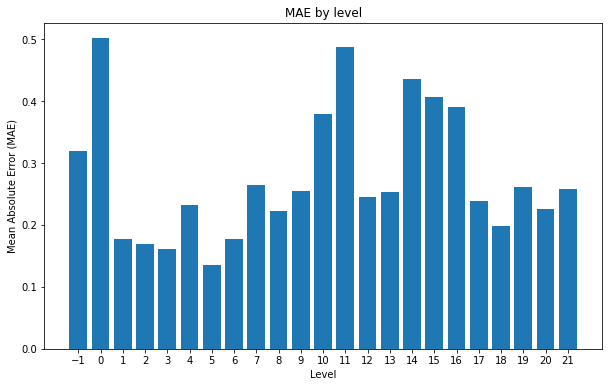

In [42]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.03
RMSE: 0.18

Round type: round
MSE: 0.04
RMSE: 0.20

Round type: 0.33
MSE: 0.05
RMSE: 0.22

Round type: 0.45
MSE: 0.04
RMSE: 0.20



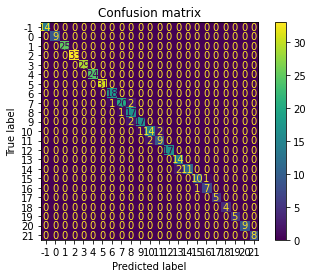

In [44]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [45]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,50,0.913544,0.955795,0.459630
1,chronological,Optuna,50,0.769451,0.877184,0.441060
2,random,normal,50,0.137900,0.371349,0.246737
3,random,Optuna,50,0.097734,0.312624,0.221938


In [46]:
from training.results import plot_summary

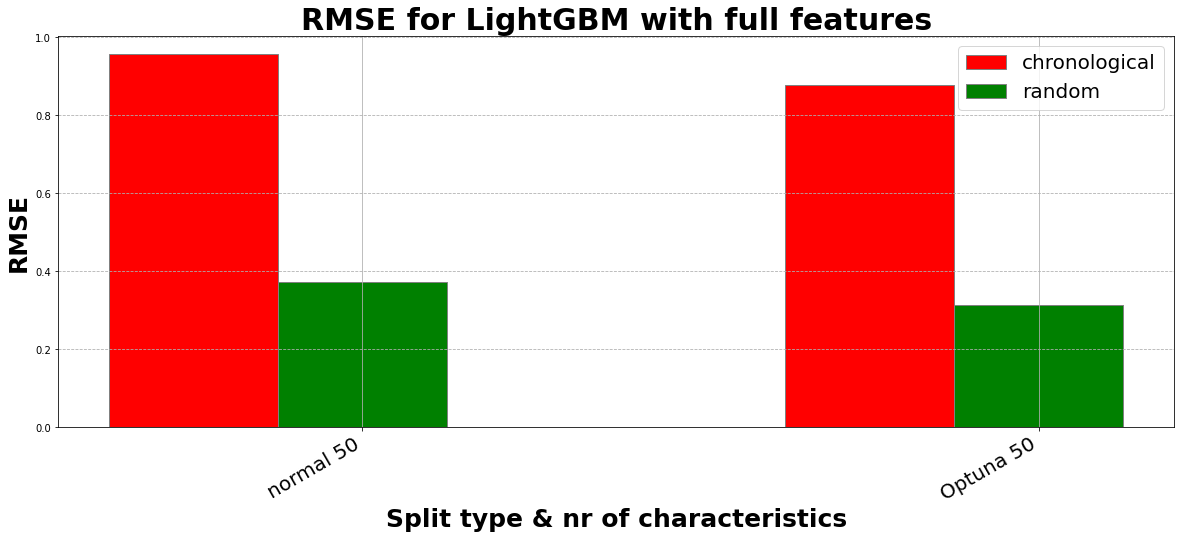

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

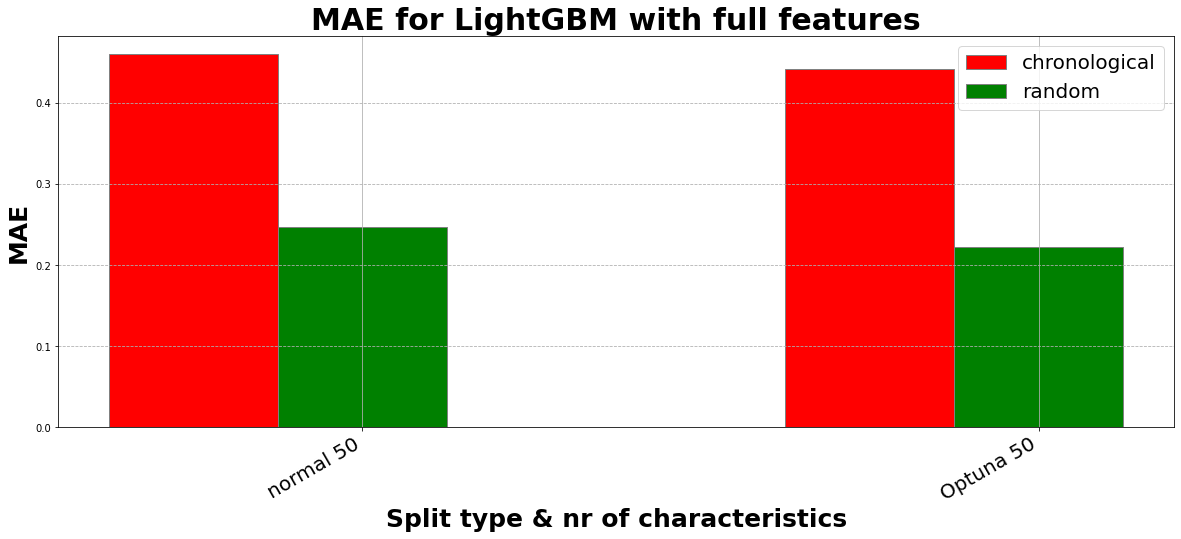

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [49]:
results.to_json("./lightgbm_final_results.json")